This notebook shows example of using "EXPORT_PIPELINE" parameter in TPOT regression model.

## <H2> Set up the development environment</H2>

In [ ]:
##After executing this code, automatically your session will be restarted witha message saying that "session crashed for unknown reason".
%%capture
! pip install DXC-Industrialized-AI-Starter
import os
os.kill(os.getpid(), 9)

From DXC-Industrialized-AI-Starter library import dxc-ai package to use it for further work.


In [ ]:
%%capture
from dxc import ai

## <H2> Access the raw data </H2>




In [ ]:
# TODO: Access raw data.
##reads json from a url and flattens it into a dataframe
data0 = ai.read_data_frame_from_remote_json("https://data.cincinnati-oh.gov/resource/ucjy-ykv4.json")
data0.head()

,request_id,request_status,funding_source,request_type,department_name,fiscal_year,replacement_body_style,equipment_class,equip_id_to_replace,replacement_make,replacement_model,date_fleet_doc_entered,fleet_document_type,est_unit_cost,actual_unit_cost,procurement_plan,date_po_awarded,purchasing_bid_date,date_bid_closed
0,818,Completed,Other,Supplemental Request,Police,2017,SUV,PC-GS,TBD,Chevrolet,Traverse,2020-06-01T00:00:00.000,DO,25799.5,25799.5,Passenger Cars,NaN,NaN,NaN
1,772,On Order,CAP,Fleet Procurement Plan,Police,2020,SEDAN,PC-GS,03240,Chevrolet,Malibu,2020-04-24T00:00:00.000,RQS,18000,17538.76,Passenger Cars,2020-05-15T00:00:00.000,NaN,NaN
2,817,Completed,Other,Supplemental Request,Police,2018,SUV,PC-GS,TBD,Jeep,Cherokee,2020-05-19T00:00:00.000,DO,24614,24614,Passenger Cars,NaN,NaN,NaN
3,774,On Order,CAP,Fleet Procurement Plan,Police,2020,SEDAN,PC-GS,05173,Chevrolet,Malibu,2020-04-24T00:00:00.000,RQS,18000,17538.76,Passenger Cars,2020-05-15T00:00:00.000,NaN,NaN
4,816,Completed,Other,Supplemental Request,Police,2020,Sedan,PC-GS,TBD,Honda,Accord,2020-05-04T00:00:00.000,DO,22118,22118,Passenger Cars,NaN,NaN,NaN


### <H2> Define data fields </H2>
Mention the <code>text_fileds</code>,<code>date_fields</code>,<code>numeric_fields</code> and <code>categorical_fields</code> as per you data set. Below are example only.

In [ ]:
# TODO: define the data fields
text_fields = []
date_fields = ['date_fleet_doc_entered', 'purchasing_bid_date', 'date_bid_closed', 'date_po_awarded']
numeric_fields = ['est_unit_cost', 'actual_unit_cost']
categorical_fields = ['request_id','request_status', 'funding_source', 'request_type', 'department_name', 
                      'fiscal_year', 'replacement_body_style','equipment_class','equip_id_to_replace',
                      'replacement_make', 'replacement_model','fleet_document_type', 'procurement_plan']

### <H2> Clean the raw data </H2>
Execute <code>raw_data</code> so that it accesses your raw data and returns it as a Pandas dataframe. Any preprocessing of the raw data should be done here. 

In [ ]:
#clean the data
impute = True
data1 = ai.clean_dataframe(data0, impute, text_fields, date_fields, numeric_fields, categorical_fields)

#display excerpts of the raw data
data1.head()

,request_id,request_status,funding_source,request_type,department_name,fiscal_year,replacement_body_style,equipment_class,equip_id_to_replace,replacement_make,replacement_model,date_fleet_doc_entered,fleet_document_type,est_unit_cost,actual_unit_cost,procurement_plan,date_po_awarded,purchasing_bid_date,date_bid_closed
0,818,Completed,Other,Supplemental Request,Police,2017,SUV,PC-GS,TBD,Chevrolet,Traverse,2020-06-01T00:00:00+00:00,DO,25799.5,25799.50,Passenger Cars,2020-06-12T00:00:00+00:00,2020-04-29T00:00:00+00:00,2020-06-19T00:00:00+00:00
1,772,On Order,CAP,Fleet Procurement Plan,Police,2020,SEDAN,PC-GS,03240,Chevrolet,Malibu,2020-04-24T00:00:00+00:00,RQS,18000.0,17538.76,Passenger Cars,2020-05-15T00:00:00+00:00,2020-01-27T00:00:00+00:00,2020-02-11T00:00:00+00:00
2,817,Completed,Other,Supplemental Request,Police,2018,SUV,PC-GS,TBD,Jeep,Cherokee,2020-05-19T00:00:00+00:00,DO,24614.0,24614.00,Passenger Cars,2020-06-12T00:00:00+00:00,2020-04-29T00:00:00+00:00,2020-06-19T00:00:00+00:00
3,774,On Order,CAP,Fleet Procurement Plan,Police,2020,SEDAN,PC-GS,05173,Chevrolet,Malibu,2020-04-24T00:00:00+00:00,RQS,18000.0,17538.76,Passenger Cars,2020-05-15T00:00:00+00:00,2020-01-27T00:00:00+00:00,2020-02-11T00:00:00+00:00
4,816,Completed,Other,Supplemental Request,Police,2020,Sedan,PC-GS,TBD,Honda,Accord,2020-05-04T00:00:00+00:00,DO,22118.0,22118.00,Passenger Cars,2020-06-12T00:00:00+00:00,2019-08-13T00:00:00+00:00,2020-06-19T00:00:00+00:00


## <H1>Build a data pipeline</H1>

In [ ]:
# TODO: specify the details of the data layer
data_layer = {
    "connection_string": "<your connection_string>",
    "collection_name": "<your collection_name>",
    "database_name": "<your database_name>",
    "data_source":"<Source of your datset>",
    "cleaner":"<whether applied cleaner yes/no >"
}

Inject data into MongoDB

In [ ]:
data2 = ai.write_raw_data(data_layer, data1, date_fields)

In [ ]:
# TODO: define the code needed to refine the raw data
def data_pipeline():

  pipe = [
          {
              '$group':{
                  '_id': {
                      "funding_source":"$funding_source",
                      "request_type":"$request_type",
                      "department_name":"$department_name",
                      "replacement_body_style":"$replacement_body_style",
                      "equipment_class":"$equipment_class",
                      "replacement_make":"$replacement_make",
                      "replacement_model":"$replacement_model",
                      "procurement_plan":"$procurement_plan"
                      },
                  "avg_est_unit_cost":{"$avg":"$est_unit_cost"},
                  "avg_est_unit_cost_error":{"$avg":{ "$subtract": [ "$est_unit_cost", "$actual_unit_cost" ] }}
              }
          }
  ]

  return pipe

df = ai.access_data_from_pipeline(data2, data_pipeline())
df.head()

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,avg_est_unit_cost,avg_est_unit_cost_error,_id.funding_source,_id.request_type,_id.department_name,_id.replacement_body_style,_id.equipment_class,_id.replacement_make,_id.replacement_model,_id.procurement_plan
0,52000.00,4020.00,CIP,Fleet Procurement Plan,Park Department,CAB & CHASSiS W/ UTILITY BODY,Vans,FORD,TRANIST 350,Van
1,232516.00,7566.86,CIP,Fleet Procurement Plan,Fire,MEDIC UNIT,AMBULANCE,FORD,F450 - HORTON MEDIC UNIT,Medic Units
2,32000.00,-26421.25,CIP,Fleet Procurement Plan,Park Department,TRACTOR,GROUNDS,4100D,TORO,Horticulture
3,19333.50,0.00,Other,Supplemental Request,Police,SUV,PC-GS,Chevrolet,Equinox,Passenger Cars
4,9472.64,-28477.36,Mixed Funding,Supplemental Request,Police,ATV,SPECIALIZED SMALL,John Deere,Gator,Specialized Small


## <H1>Run an experiment</H1>

**TPOT Classification/Regression:**
Machine learning is  typically a very time-consuming and knowledge-intensive part of a data science problem. Auto-ml is not designed to replace the data scientist, but rather free her to work on more important aspects of the complete problem, such as acquiring data and interpreting the model results.[TPOT](https://epistasislab.github.io/tpot) is a Python library developed for automatic machine learning feature preprocessing, model selection, and hyperparameter tuning. AI Starter has integrated TPOT as one of its Auto Ml libraries. 

Please refer the below parameter description for best utilization of Tpot classification and regression methods with AI Starter.<br> 

**<code>export_pipeline: True/False</code>** This parameter automatically exports the corresponding Python code for the optimized pipeline to a python file and saves the python file and encoded data_file in your current directory. <code>best_pipeline.py</code> will contain the Python code for the optimized pipeline. The default value for this parameter is 'True'. We suggest not changing the value as the optimized pipeline code will help to evaluate your model using model explainability which will be one of the tasks to achieve the AI Forensics badge.



**export_pipeline = False**

In [ ]:
# TODO: design and run an experiment
experiment_design = {
    #model options include ['tpot_regression()', 'tpot_classification()','timeseries()']
    "model": ai.tpot_regression(),
    "labels": df.avg_est_unit_cost_error,
    "data": df,
    #Tell the model which column is 'output'
    #Also note columns that aren't purely numerical
    #Examples include ['nlp', 'date', 'categorical', 'ignore']
    "meta_data": {
      "avg_est_unit_cost_error": "output",
      "_id.funding_source": "categorical",
      "_id.department_name": "categorical",
      "_id.replacement_body_style": "categorical",
      "_id.replacement_make": "categorical",
      "_id.replacement_model": "categorical",
      "_id.procurement_plan": "categorical"
  }
}

#config_dict = {'sklearn.ensemble.GradientBoostingRegressor':{}}

trained_model = ai.run_experiment(experiment_design, verbose = True, max_time_mins = 5, max_eval_time_mins = 0.04, config_dict = None, warm_start = False, export_pipeline = False, scoring = None)


Generation 1 - Current best internal CV score: -639396267.6654692

Generation 2 - Current best internal CV score: -583530707.2900026

Generation 3 - Current best internal CV score: -583530707.2900026

5.00 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBRegressor(LinearSVR(input_matrix, C=5.0, dual=True, epsilon=0.01, loss=epsilon_insensitive, tol=0.001), learning_rate=0.5, max_depth=5, min_child_weight=11, n_estimators=100, nthread=1, objective=reg:squarederror, subsample=1.0)

r2 Score: 0.5838709984236775

Negative mean square error: -1762408107.938679

Negative root mean square error: -41981.04462657735

explained_variance: 0.590801937084218

Negative_mean_absolute_error: -17125.01999361687

Negative_median_absolute_error: -5096.9169921875



When the export_pipeline is set to false, best pipeline is not saved into directory.

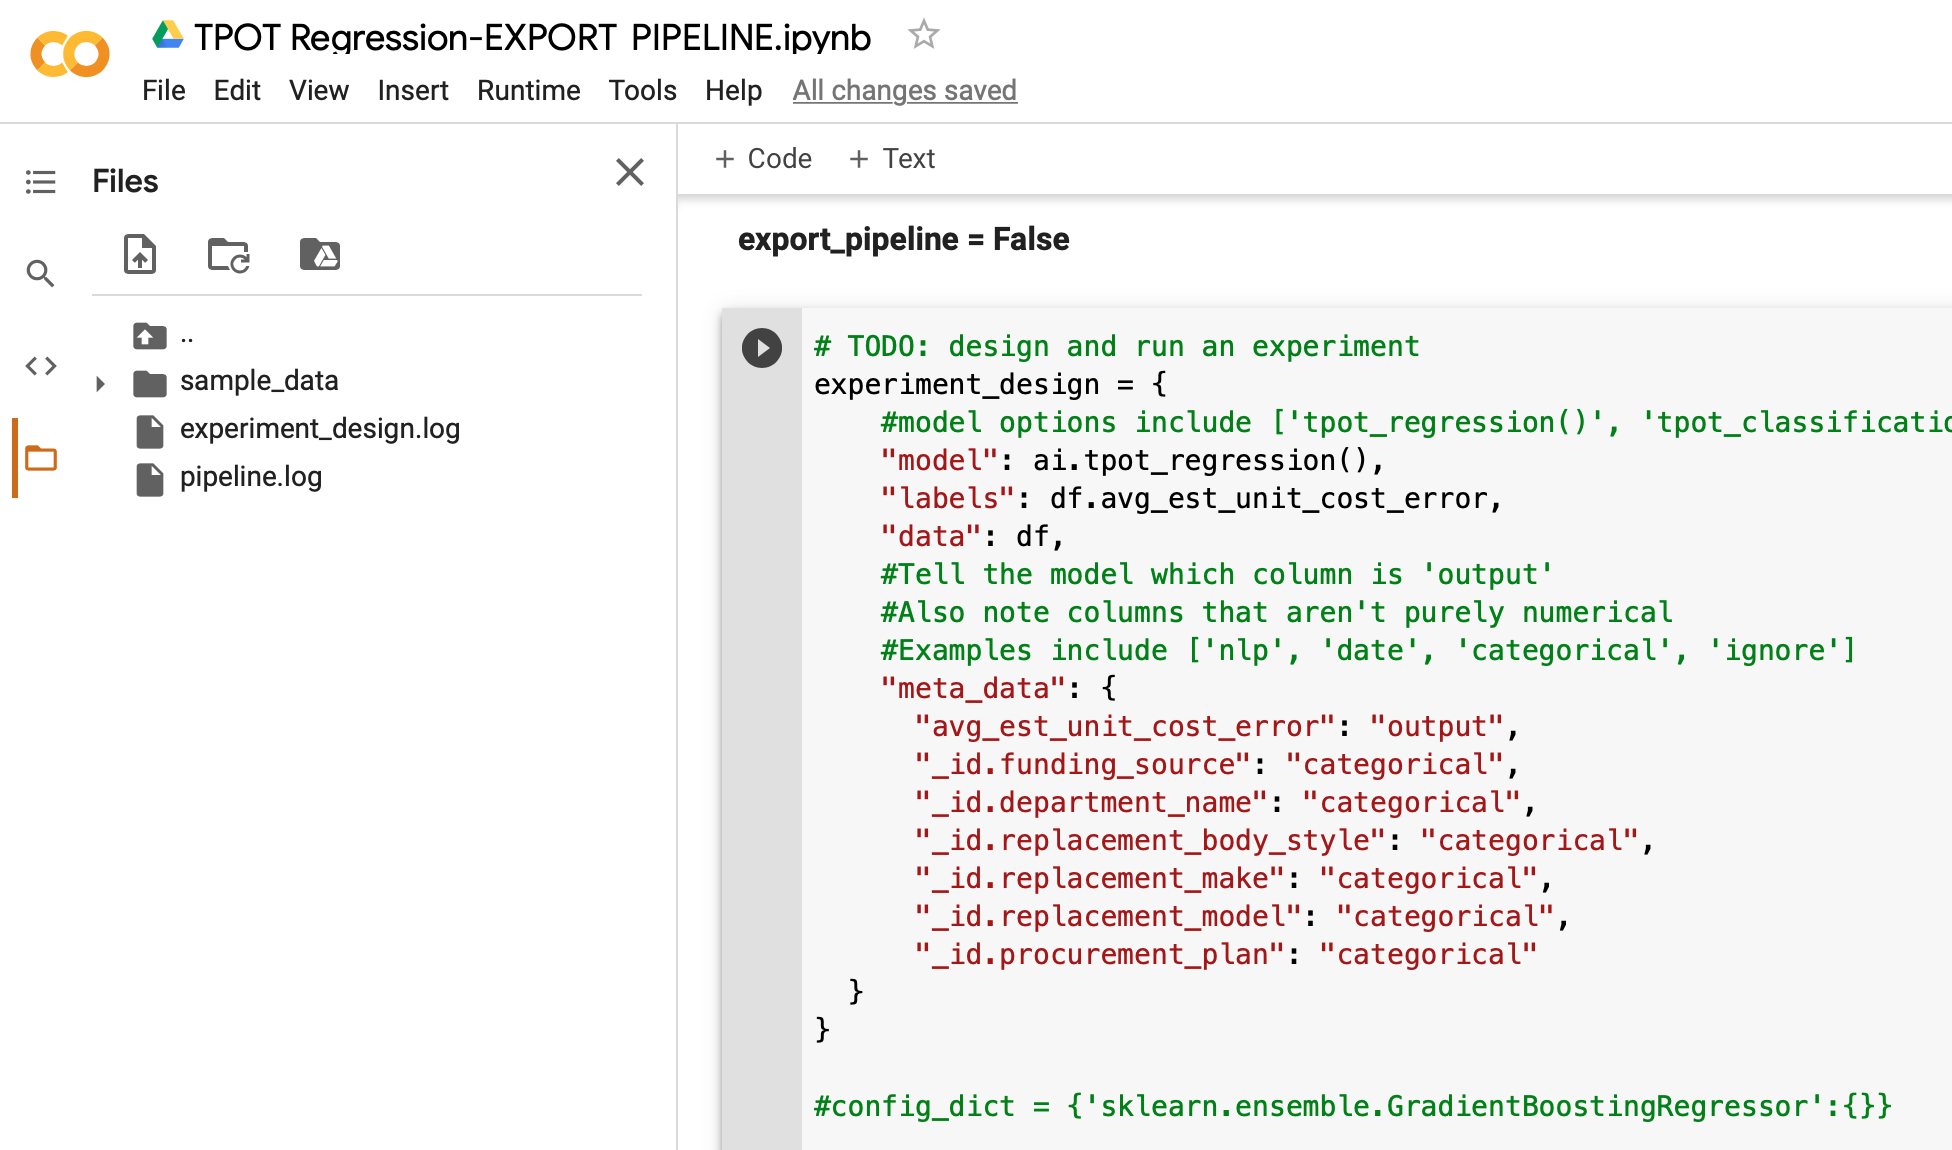

In [ ]:
from IPython.display import Image, display
display(Image('1.png'))

**export_pipeline = True**


In [ ]:
# TODO: design and run an experiment
experiment_design = {
    #model options include ['tpot_regression()', 'tpot_classification()','timeseries()']
    "model": ai.tpot_regression(),
    "labels": df.avg_est_unit_cost_error,
    "data": df,
    #Tell the model which column is 'output'
    #Also note columns that aren't purely numerical
    #Examples include ['nlp', 'date', 'categorical', 'ignore']
    "meta_data": {
      "avg_est_unit_cost_error": "output",
      "_id.funding_source": "categorical",
      "_id.department_name": "categorical",
      "_id.replacement_body_style": "categorical",
      "_id.replacement_make": "categorical",
      "_id.replacement_model": "categorical",
      "_id.procurement_plan": "categorical"
  }
}

#config_dict = {'sklearn.ensemble.GradientBoostingRegressor':{}}

trained_model = ai.run_experiment(experiment_design, verbose = True, max_time_mins = 5, max_eval_time_mins = 0.04, config_dict = None, warm_start = False, export_pipeline = True, scoring = None)


Generation 1 - Current best internal CV score: -660429619.9156574

Generation 2 - Current best internal CV score: -609378034.3000071

Generation 3 - Current best internal CV score: -609378034.3000071

5.00 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsRegressor(GradientBoostingRegressor(MaxAbsScaler(input_matrix), alpha=0.99, learning_rate=0.01, loss=huber, max_depth=8, max_features=0.5, min_samples_leaf=18, min_samples_split=5, n_estimators=100, subsample=1.0), n_neighbors=54, p=1, weights=distance)

r2 Score: 0.5166345521092552

Negative mean square error: -2047170904.2942407

Negative root mean square error: -45245.67276872166

explained_variance: 0.524601486279523

Negative_mean_absolute_error: -15730.198595593796

Negative_median_absolute_error: -3854.6325316678754



When the export_pipeline is set to True, best pipeline is saved into directory as highlighted below.

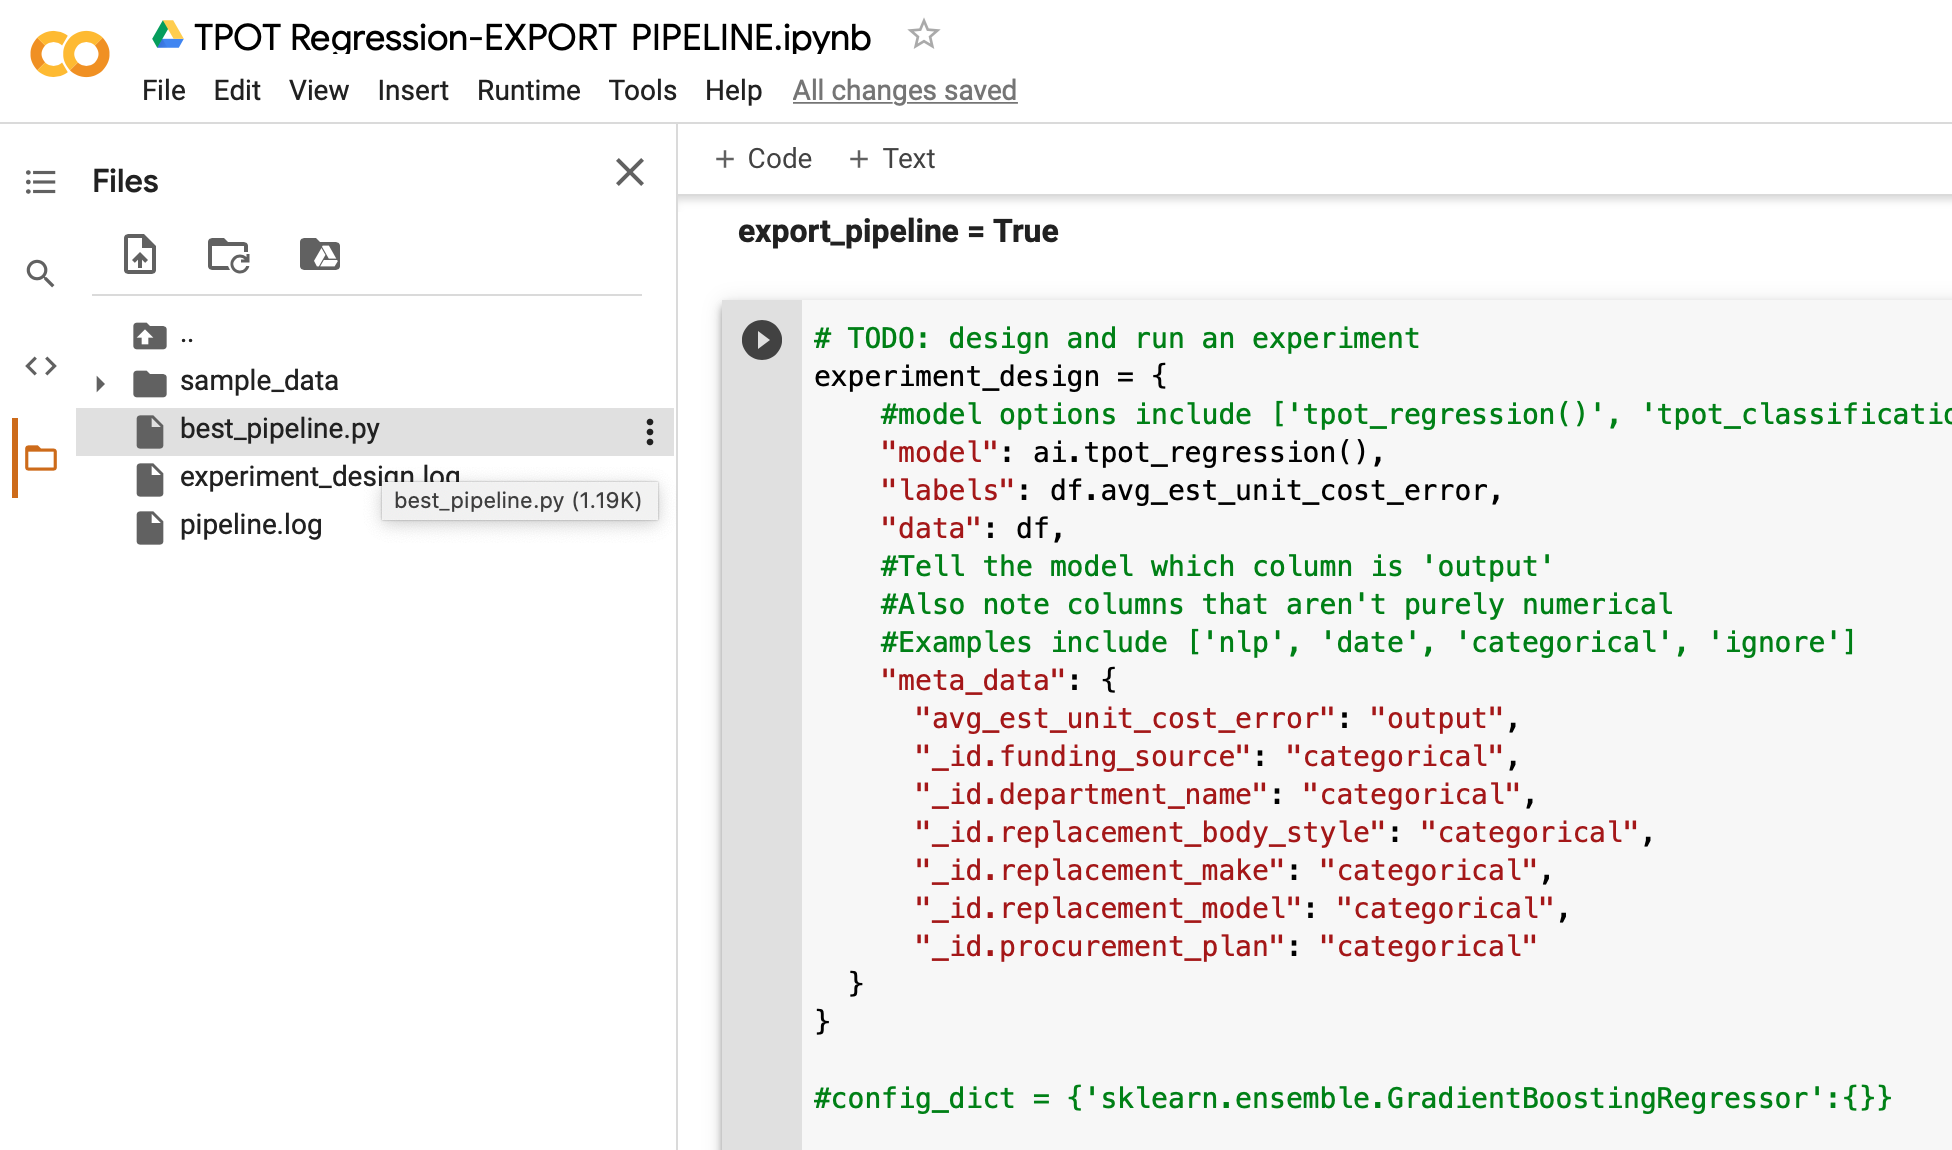

In [ ]:
display(Image('2.png'))